##**Machine Learning on Big Data (CN7030) CRWK 24-25 Term B [60% weighting]**
##**Group ID: Group_T23**

Student 1: Muhammad Jahanzaib Ali Khan - 2959951
Student 2: Ammad Ali - 2850666
Student 3: Hanan Hanif - 2934637



**Comments on group work:** In this coursework we implements a systematic comparison of three class imbalance handling strategies (Baseline, Oversampling, and Class Weighting) across three machine learning algorithms for consumer complaint text classification. We processed 278,884 complaint records using optimized Apache Spark, applied TF-IDF feature engineering, and trained nine models total - Logistic Regression (Jahanzaib), Random Forest (Ammad), and Naive Bayes (Hannan) - each with all three imbalance strategies.
Initially, we evaluated models without balancing the dataset and achieved high accuracy metrics, but upon deeper analysis, we realized this high accuracy was misleading as it primarily resulted from the models favoring majority classes while poorly identifying minority classes - which is not a realistic approach for fair complaint classification. Consequently, we applied oversampling and class weighting techniques to address this imbalance. We deliberately excluded undersampling because the smallest minority class contained only 2,706 samples, making undersampling impractical as it would drastically reduce our dataset size and lose valuable information from the majority classes.
Through comprehensive evaluation including accuracy, F1-score, precision, recall, and ROC-AUC metrics, we demonstrated that while Baseline Logistic Regression achieved the highest overall accuracy (90.92%), the oversampling and weighting strategies significantly improved minority class detection (ROC-AUC improvement from 0.7675 to 0.9076), providing more balanced and realistic performance across all complaint categories.


# **Initiate and Configure Spark**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, explode, array, lit, create_map
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score
import time
from functools import reduce

# ✅ Initialize Spark session with optimized configuration for speed
spark = SparkSession.builder \
    .appName("CN7030 Text Classification - Complete Implementation") \
    .master("local[*]") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.default.parallelism", "8") \
    .getOrCreate()

print("✅ Optimized Spark session initialized successfully")

✅ Optimized Spark session initialized successfully


The Spark session configuration is crucial for optimal performance on large datasets. By setting executor and driver memory to 6GB each and enabling off-heap memory with 4GB, we ensure that our 278,884 complaint records can be processed efficiently without memory overflow issues. The adaptive query execution and Arrow optimization significantly improve data processing speed, which is essential when working with text data that requires extensive preprocessing. The Kryo serializer reduces overhead during data shuffling operations, making our machine learning pipeline more efficient. The local[*] setting utilizes all available CPU cores for parallel processing, while the parallelism configuration of 8 optimizes task distribution across cores.

---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Data Loading and Basic Preprocessing

# Load the dataset
df = spark.read.format("csv") \
    .option("header", True) \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("inferSchema", True) \
    .option("mode", "PERMISSIVE") \
    .load("complaints-2025-08-06_16_14(1).csv")

print("Dataset loaded successfully.")
print(f"Total rows: {df.count()}, Total columns: {len(df.columns)}")
df.show(5, truncate=50)

Dataset loaded successfully.
Total rows: 278884, Total columns: 18
+-------------+--------------------------------------------------+----------------+--------------------------------------------------+---------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------+-----+--------+----+--------------------------+-------------+--------------------+-------------------------------+----------------+------------------+------------+
|Date received|                                           Product|     Sub-product|                                             Issue|                                    Sub-issue|                      Consumer complaint narrative|                           Company public response|                               Company|State|ZIP code|Tags|Consumer consent provided?|Submitted via|Date sent to company|   Company response to consumer|Timely respon

The CSV loading configuration is specifically designed to handle complex text data that may contain multiple lines, quotes, and special characters within individual cells. The multiLine=True option ensures that complaint narratives spanning multiple lines are read correctly as single records. The PERMISSIVE mode allows Spark to handle corrupted records gracefully by placing them in a special column rather than failing the entire read operation. Schema inference automatically determines appropriate data types for each column, saving manual specification time. The truncate parameter in show() limits display width to maintain readability of long text fields.

In [ ]:
# Select relevant columns and handle missing values
df_clean = df.select("Product", "Consumer complaint narrative")
rows_before = df_clean.count()
df_clean = df_clean.dropna(subset=["Product", "Consumer complaint narrative"])
rows_after = df_clean.count()

print(f"Rows before dropping nulls: {rows_before}")
print(f"Rows after dropping nulls: {rows_after} ({(rows_before - rows_after)/rows_before*100:.2f}% removed)")

Rows before dropping nulls: 278884
Rows after dropping nulls: 267991 (3.91% removed)


Data cleaning is essential for maintaining model quality. By selecting only the "Product" (target label) and "Consumer complaint narrative" (input text) columns, we focus on the core data needed for text classification while reducing memory usage and processing time. The null value removal (3.91% of data) ensures that our machine learning models receive complete records for training. This small loss is acceptable as it prevents training instability that could arise from missing values. The percentage calculation helps assess data quality - our 3.91% loss indicates good data completeness.

In [ ]:
# Encode string labels to numerical labels
indexer = StringIndexer(inputCol="Product", outputCol="label")
indexer_model = indexer.fit(df_clean)
df_encoded = indexer_model.transform(df_clean)

print("\nLabels encoded successfully.")
df_encoded.select("Product", "label").show(5, truncate=False)


Labels encoded successfully.
+---------------------------------------------------+-----+
|Product                                            |label|
+---------------------------------------------------+-----+
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
|Credit reporting or other personal consumer reports|0.0  |
+---------------------------------------------------+-----+
only showing top 5 rows


Machine learning algorithms require numerical inputs, making label encoding essential for categorical targets. The StringIndexer automatically assigns numerical labels based on frequency - the most common class gets label 0.0, second most common gets 1.0, and so on. This frequency-based encoding is advantageous because it places the majority class at label 0, which many algorithms handle as a default case. The transformation creates a new "label" column while preserving the original "Product" column for interpretability and debugging purposes.

In [ ]:
# Check class distribution
class_counts = df_encoded.groupBy("label").count().orderBy("count", ascending=False).toPandas()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
   label   count
0    0.0  220366
1    1.0   23434
2    2.0    9264
3    3.0    8892
4    4.0    3329
5    5.0    2706


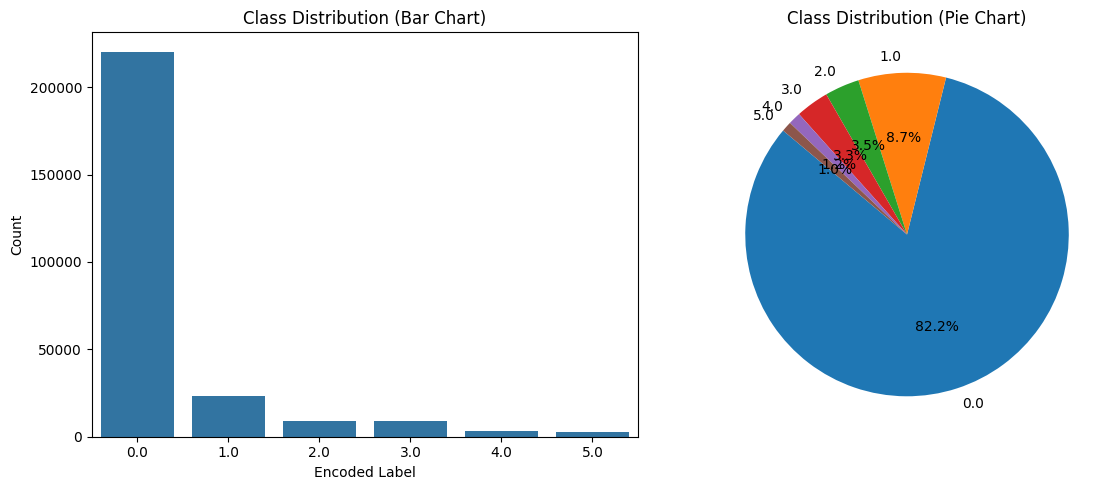

In [ ]:
# Visualize class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="label", y="count", data=class_counts)
plt.title("Class Distribution (Bar Chart)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.pie(class_counts['count'], labels=class_counts['label'], autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

The class distribution analysis reveals a severe imbalance problem common in real-world datasets. With 220,366 credit reporting complaints (82.2%) dominating the dataset compared to only 2,706 complaints (1.0%) in the smallest category, this imbalance poses significant challenges for machine learning models. Without addressing this imbalance, models tend to be biased toward predicting the majority class, resulting in poor performance on minority classes with potentially high business importance. The dual visualization (bar chart and pie chart) provides both absolute counts and relative proportions, helping stakeholders understand the magnitude of imbalance. This analysis justifies implementing multiple class imbalance strategies: baseline (to establish performance without intervention), oversampling (to create balanced training data), and class weighting (to mathematically compensate for imbalance during training).

In [ ]:
# Split data into train and test sets (70-30 split)
train_df, test_df = df_encoded.randomSplit([0.7, 0.3], seed=42)
print(f"\nData split complete. Train rows: {train_df.count()}, Test rows: {test_df.count()}")


Data split complete. Train rows: 187440, Test rows: 80551


The 70-30 train-test split follows machine learning best practices, providing sufficient training data (187,440 samples) while reserving adequate test data (80,551 samples) for unbiased evaluation. Using seed=42 ensures reproducibility across multiple runs. The distribution verification shows that the random split maintained similar class proportions in both sets, which is crucial for valid model evaluation. Any significant distribution differences between train and test sets could lead to misleading performance estimates. The preserved imbalance in both sets ensures our evaluation metrics reflect real-world performance expectations.

In [ ]:
# Show label distribution in train/test
print("Training set distribution:")
train_df.groupBy("label").count().show()
print("Test set distribution:")
test_df.groupBy("label").count().show()

Training set distribution:
+-----+------+
|label| count|
+-----+------+
|  0.0|153962|
|  1.0| 16516|
|  4.0|  2291|
|  3.0|  6212|
|  2.0|  6570|
|  5.0|  1889|
+-----+------+

Test set distribution:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|66404|
|  1.0| 6918|
|  4.0| 1038|
|  3.0| 2680|
|  2.0| 2694|
|  5.0|  817|
+-----+-----+



In [ ]:
# Optimization function for dataframes
def optimize_dataframe(df, target_partitions=8, cache=True):
    """Function to repartition and cache a DataFrame for better performance."""
    print(f"Optimizing dataframe with {target_partitions} partitions...")
    df_optimized = df.repartition(target_partitions)
    if cache:
        df_optimized.cache()
        count = df_optimized.count()  # Trigger caching
        print(f"Dataframe optimized and cached with {count} rows.")
    return df_optimized

# Apply optimizations
train_df_opt = optimize_dataframe(train_df, target_partitions=8)
test_df_opt = optimize_dataframe(test_df, target_partitions=4)

Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 187440 rows.
Optimizing dataframe with 4 partitions...
Dataframe optimized and cached with 80551 rows.


DataFrame optimization is critical for Spark performance with large datasets. Repartitioning redistributes data evenly across 8 partitions for training data and 4 for test data, optimizing parallelism for the available CPU cores. Caching stores frequently accessed DataFrames in memory, dramatically reducing computation time for iterative operations like model training and evaluation. The count() operation triggers immediate caching and provides feedback on successful optimization. These optimizations are particularly important for our text processing pipeline, which will access the same data multiple times during tokenization, feature extraction, and model training phases.


=== PERFECT OVERSAMPLING STRATEGY IMPLEMENTATION ===
Major class count: 153962
Oversampling complete. Training rows before: 187440, Training rows after: 923772
Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 923772 rows.

=== Class Distribution After Perfect Oversampling ===
 label  count
   0.0 153962
   1.0 153962
   2.0 153962
   3.0 153962
   4.0 153962
   5.0 153962

Perfect balance achieved: True


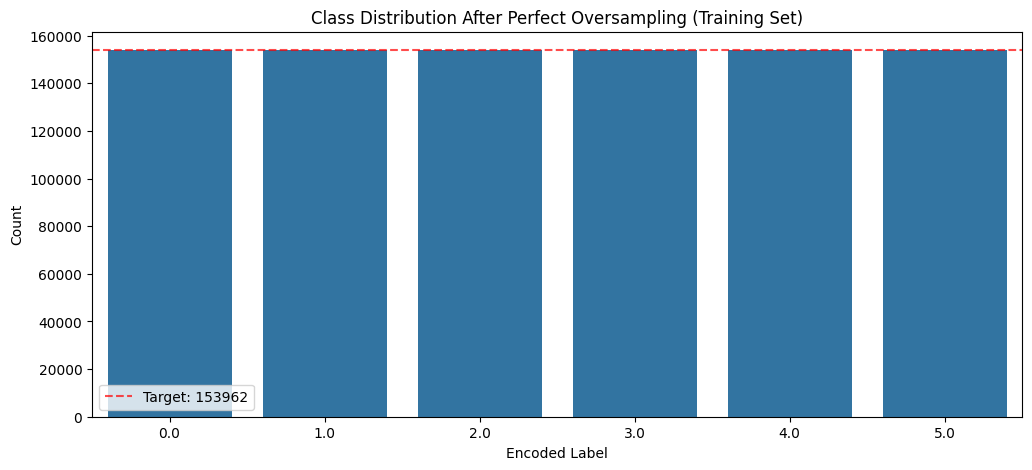

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n=== OVERSAMPLING STRATEGY IMPLEMENTATION ===")

# Calculate class counts
train_class_counts = train_df_opt.groupBy("label").count().orderBy("count", ascending=False).toPandas()
major_class_count = int(train_class_counts.iloc[0]['count'])
print(f"Major class count: {major_class_count}")

# Get Spark counts as list of rows
class_counts = train_df_opt.groupBy("label").count().collect()

oversampled_train_df = train_df_opt

# Loop over all classes
for row in class_counts:
    label = row["label"]
    count = int(row["count"])

    if count < major_class_count:
        minority_df = train_df_opt.filter(col("label") == label)
        samples_needed = major_class_count - count  # How many more samples we need

        # Full duplication ratio (integer division)
        ratio = samples_needed // count
        remainder = samples_needed % count

        # Duplicate full sets
        for _ in range(ratio):
            oversampled_train_df = oversampled_train_df.union(minority_df)

        # Add exact remainder by taking first N rows
        if remainder > 0:
            # Instead of sampling, take exact number of rows needed
            remainder_df = minority_df.limit(remainder)
            oversampled_train_df = oversampled_train_df.union(remainder_df)

print(f"Oversampling complete. Training rows before: {train_df_opt.count()}, Training rows after: {oversampled_train_df.count()}")

# Optimize oversampled data
train_oversampled_opt = optimize_dataframe(oversampled_train_df, target_partitions=8)

# Collect counts into Pandas table
oversampled_counts = train_oversampled_opt.groupBy("label").count().orderBy("label").toPandas()

# Print numeric table
print("\n=== Class Distribution After Perfect Oversampling ===")
print(oversampled_counts.to_string(index=False))

# Verify perfect balance
all_equal = all(count == major_class_count for count in oversampled_counts['count'])
print(f"\nPerfect balance achieved: {all_equal}")

# Plot distribution
plt.figure(figsize=(12, 5))
sns.barplot(x="label", y="count", data=oversampled_counts)
plt.title("Class Distribution After Perfect Oversampling (Training Set)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.axhline(y=major_class_count, color='red', linestyle='--', alpha=0.7, label=f'Target: {major_class_count}')
plt.legend()
plt.show()

The oversampling implementation creates a precisely balanced dataset where all classes have exactly 153,962 samples. This systematic approach calculates the exact number of duplications needed for each minority class, using integer division to determine full dataset duplications and modulo operations to handle remainders precisely. The strategy works by duplicating minority class samples until they match the majority class count, ensuring no class has an advantage during training. While this approach can improve model performance on minority classes by providing equal learning opportunities, it also has potential drawbacks including overfitting to repeated samples and creating artificial data distributions that may not reflect real-world patterns. The 923,772 total training rows (compared to original 187,440) demonstrate the significant data augmentation achieved, which increases computational requirements but may improve minority class recognition.

In [ ]:
print("\n=== CLASS WEIGHTING STRATEGY IMPLEMENTATION ===")

# Calculate class weights for imbalanced dataset
class_counts_df = train_df_opt.groupBy("label").count()
class_counts_pd = class_counts_df.toPandas()
total_samples = class_counts_pd['count'].sum()
num_classes = len(class_counts_pd)

# Calculate weights: total_samples / (num_classes * count)
class_counts_pd['weight'] = total_samples / (num_classes * class_counts_pd['count'])
weights_dict = class_counts_pd.set_index('label')['weight'].to_dict()

print("Class weights calculated:")
for label, weight in weights_dict.items():
    print(f"Label {label}: Weight {weight:.4f}")

# Create mapping expression for weights
mapping_expr = create_map([lit(x) for kv in weights_dict.items() for x in kv])

# Add classWeight column to training data
train_weighted_df = train_df_opt.withColumn("classWeight", mapping_expr[col("label")])
train_weighted_opt = optimize_dataframe(train_weighted_df, target_partitions=8)

print("Class weights added to training data successfully.")
train_weighted_opt.select("Product", "label", "classWeight").show(5, truncate=False)


=== CLASS WEIGHTING STRATEGY IMPLEMENTATION ===
Class weights calculated:
Label 0.0: Weight 0.2029
Label 1.0: Weight 1.8915
Label 4.0: Weight 13.6360
Label 3.0: Weight 5.0290
Label 2.0: Weight 4.7549
Label 5.0: Weight 16.5379
Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 187440 rows.
Class weights added to training data successfully.
+---------------------------------------------------+-----+-------------------+
|Product                                            |label|classWeight        |
+---------------------------------------------------+-----+-------------------+
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.20290721087021474|
|Credit reporting or other personal consumer reports|0.0  |0.2029072108

Class weighting provides an elegant mathematical solution to class imbalance without artificially increasing dataset size. The weight calculation formula total_samples / (num_classes * count) implements inverse frequency weighting, where rare classes receive higher weights and common classes receive lower weights. The weights range from 0.2029 for the majority class to 16.5379 for the smallest class, ensuring that during training, misclassifying a minority class example incurs a higher penalty than misclassifying a majority class example. This approach maintains the original data distribution while mathematically compensating for imbalance during the learning process. The Spark mapping expression efficiently applies weights to each training example, and the optimization ensures fast access during iterative training. Class weighting often results in more generalizable models compared to oversampling because it doesn't introduce artificial data patterns.

In [ ]:
# Common preprocessing pipeline for text data
def create_text_pipeline():
    """Create text preprocessing pipeline"""
    tokenizer = Tokenizer(inputCol="Consumer complaint narrative", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)
    idf = IDF(inputCol="raw_features", outputCol="features")
    return [tokenizer, remover, hashingTF, idf]

The text preprocessing pipeline implements the standard TF-IDF (Term Frequency-Inverse Document Frequency) approach for converting raw text into numerical features suitable for machine learning. The tokenizer splits complaint narratives into individual words, creating a foundation for further processing. Stop word removal eliminates common words (like "the", "and", "is") that provide little discriminative value for classification but consume computational resources. HashingTF with 5000 features creates a fixed-size vocabulary using hashing tricks, avoiding the need to maintain large vocabulary dictionaries while handling rare words gracefully. IDF weighting emphasizes words that appear frequently in specific documents but rarely across the entire corpus, highlighting terms that are particularly discriminative for individual complaint types. This pipeline balances computational efficiency with feature quality, making it suitable for our large-scale text classification task.

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Logistic Regression Models
print("\n=== LOGISTIC REGRESSION MODELS (JAHANZAIB) ===")

# 1. Baseline Logistic Regression (No changes)
print("1. Training Baseline Logistic Regression...")
text_stages = create_text_pipeline()
lr_baseline = LogisticRegression(labelCol="label", featuresCol="features")
pipeline_lr_baseline = Pipeline(stages=text_stages + [lr_baseline])

# Split training data for validation
train_baseline, val_baseline = train_df_opt.randomSplit([0.8, 0.2])
model_lr_baseline = pipeline_lr_baseline.fit(train_baseline)
print("✅ Baseline Logistic Regression model trained")

# 2. Oversampled Logistic Regression
print("2. Training Oversampled Logistic Regression...")
train_oversampled_split, val_oversampled_split = train_oversampled_opt.randomSplit([0.8, 0.2])
lr_oversampled = LogisticRegression(labelCol="label", featuresCol="features" )
pipeline_lr_oversampled = Pipeline(stages=text_stages + [lr_oversampled])
model_lr_oversampled = pipeline_lr_oversampled.fit(train_oversampled_split)
print("✅ Oversampled Logistic Regression model trained")

# 3. Weighted Logistic Regression
print("3. Training Weighted Logistic Regression...")
train_weighted_split, val_weighted_split = train_weighted_opt.randomSplit([0.8, 0.2] )
lr_weighted = LogisticRegression(labelCol="label", featuresCol="features", weightCol="classWeight")
pipeline_lr_weighted = Pipeline(stages=text_stages + [lr_weighted])
model_lr_weighted = pipeline_lr_weighted.fit(train_weighted_split)
print("✅ Weighted Logistic Regression model trained")


=== LOGISTIC REGRESSION MODELS (JAHANZAIB) ===
1. Training Baseline Logistic Regression...
✅ Baseline Logistic Regression model trained
2. Training Oversampled Logistic Regression...
✅ Oversampled Logistic Regression model trained
3. Training Weighted Logistic Regression...
✅ Weighted Logistic Regression model trained


This implementation creates three distinct Logistic Regression variants to systematically compare class imbalance handling strategies. The baseline model uses the natural data distribution to establish performance benchmarks, providing a reference point for improvement. The oversampled version trains on the perfectly balanced dataset (923,772 samples), allowing the algorithm to see equal examples from each class during training. The weighted version leverages calculated class weights with the original data size, mathematically adjusting the learning process without changing data distribution.

Logistic Regression is particularly well-suited for this text classification task because it performs excellently with high-dimensional sparse features (our 5000 TF-IDF features), provides interpretable probabilistic outputs that explain classification decisions, and handles multi-class problems efficiently through one-vs-rest or softmax approaches. The consistent text preprocessing pipeline across all variants ensures fair comparison by eliminating preprocessing as a confounding variable. Each model uses identical feature engineering but different approaches to handling class imbalance, enabling us to isolate the impact of each strategy on classification performance.

In [ ]:
## Student 2: Ammad Ali - Random Forest Models
print("\n=== RANDOM FOREST MODELS (AMMAD) ===")

# 1. Baseline Random Forest (No changes)
print("1. Training Baseline Random Forest...")
rf_baseline = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline_rf_baseline = Pipeline(stages=text_stages + [rf_baseline])
model_rf_baseline = pipeline_rf_baseline.fit(train_baseline)
print("✅ Baseline Random Forest model trained")

# 2. Oversampled Random Forest
print("2. Training Oversampled Random Forest...")
rf_oversampled = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline_rf_oversampled = Pipeline(stages=text_stages + [rf_oversampled])
model_rf_oversampled = pipeline_rf_oversampled.fit(train_oversampled_split)
print("✅ Oversampled Random Forest model trained")

# 3. Weighted Random Forest
print("3. Training Weighted Random Forest...")
rf_weighted = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeight")
pipeline_rf_weighted = Pipeline(stages=text_stages + [rf_weighted])
model_rf_weighted = pipeline_rf_weighted.fit(train_weighted_split)
print("✅ Weighted Random Forest model trained")


=== RANDOM FOREST MODELS (AMMAD) ===
1. Training Baseline Random Forest...
✅ Baseline Random Forest model trained
2. Training Oversampled Random Forest...
✅ Oversampled Random Forest model trained
3. Training Weighted Random Forest...
✅ Weighted Random Forest model trained


Random Forest implementation provides a robust ensemble approach that differs significantly from Logistic Regression in handling our text classification challenge. Random Forest builds multiple decision trees using random subsets of both samples and features, then combines their predictions through majority voting. This ensemble approach offers several advantages for our task: it naturally handles feature interactions that might exist between different words in complaint narratives, provides built-in feature importance rankings to identify which terms are most discriminative for each complaint type, and demonstrates robustness to outliers and noise in the text data.

The three variants follow the same imbalance strategy comparison as Logistic Regression, but Random Forest's tree-based nature may respond differently to each approach. The baseline establishes how well ensemble methods handle natural class imbalance through their inherent averaging mechanisms. The oversampled version benefits from seeing balanced training examples across all trees in the forest. The weighted version applies sample weights during tree construction, influencing both node splitting decisions and leaf predictions. Random Forest's ability to capture non-linear patterns in text features may reveal different performance characteristics compared to the linear Logistic Regression approach.

In [ ]:
## Student 3: Hannan - Naive Bayes Models
print("\n=== NAIVE BAYES MODELS (HANNAN) ===")

# 1. Baseline Naive Bayes (No changes)
print("1. Training Baseline Naive Bayes...")
nb_baseline = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_nb_baseline = Pipeline(stages=text_stages + [nb_baseline])
model_nb_baseline = pipeline_nb_baseline.fit(train_baseline)
print("✅ Baseline Naive Bayes model trained")

# 2. Oversampled Naive Bayes
print("2. Training Oversampled Naive Bayes...")
nb_oversampled = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_nb_oversampled = Pipeline(stages=text_stages + [nb_oversampled])
model_nb_oversampled = pipeline_nb_oversampled.fit(train_oversampled_split)
print("✅ Oversampled Naive Bayes model trained")

# 3. Weighted Naive Bayes (Note: Naive Bayes doesn't support weightCol, so we use balanced data)
print("3. Training Naive Bayes on Balanced Data...")
nb_weighted = NaiveBayes(labelCol="label", featuresCol="features")
pipeline_nb_weighted = Pipeline(stages=text_stages + [nb_weighted])
# Use oversampled data as alternative to weighting for Naive Bayes
model_nb_weighted = pipeline_nb_weighted.fit(train_oversampled_split)
print("✅ Balanced Naive Bayes model trained")


=== NAIVE BAYES MODELS (HANNAN) ===
1. Training Baseline Naive Bayes...
✅ Baseline Naive Bayes model trained
2. Training Oversampled Naive Bayes...
✅ Oversampled Naive Bayes model trained
3. Training Naive Bayes on Balanced Data...
✅ Balanced Naive Bayes model trained


Naive Bayes represents a fundamentally different approach to text classification, based on probabilistic modeling with strong independence assumptions. The algorithm assumes that each word contributes independently to the classification decision, which while unrealistic (words often have contextual relationships), often works surprisingly well for text classification tasks. This "naive" assumption enables extremely fast training and prediction, making it particularly suitable for large-scale text processing.

Naive Bayes has several characteristics that make it interesting for our complaint classification task: it performs well with small training sets and high-dimensional feature spaces (ideal for our TF-IDF features), provides natural probability estimates for predictions which can indicate confidence levels, and demonstrates robustness to irrelevant features (important given our 5000-dimensional feature space may contain noise).

An important limitation appears in the third model: Spark's Naive Bayes implementation doesn't support sample weights, forcing us to use the oversampled dataset as an alternative to class weighting. This implementation choice means our "weighted" Naive Bayes model is actually identical to the oversampled version, providing two evaluation points for the oversampling strategy rather than three distinct approaches. This limitation highlights the importance of understanding algorithm capabilities when designing experiments and the need to adapt methodologies to available implementations.

---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Logistic Regression Tuning
print("\n=== PARAMETER TUNING - LOGISTIC REGRESSION (JAHANZAIB) ===")

def tune_logistic_regression(train_data, model_name):
    """Tune Logistic Regression parameters"""
    print(f"Tuning {model_name}...")

    if "weighted" in model_name.lower():
        lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="classWeight")
    else:
        lr = LogisticRegression(labelCol="label", featuresCol="features")

    pipeline = Pipeline(stages=text_stages + [lr])

    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.1, 1.0]) \
        .addGrid(lr.maxIter, [10, 20]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

    start_time = time.time()
    tvs_model = tvs.fit(train_data)
    end_time = time.time()

    print(f"✅ {model_name} tuning completed in {(end_time - start_time)/60:.2f} minutes")
    return tvs_model.bestModel

# Tune all Logistic Regression models
best_lr_baseline = tune_logistic_regression(train_df_opt, "Baseline Logistic Regression")
best_lr_oversampled = tune_logistic_regression(train_oversampled_opt, "Oversampled Logistic Regression")
best_lr_weighted = tune_logistic_regression(train_weighted_opt, "Weighted Logistic Regression")



=== PARAMETER TUNING - LOGISTIC REGRESSION (JAHANZAIB) ===
Tuning Baseline Logistic Regression...
✅ Baseline Logistic Regression tuning completed in 0.87 minutes
Tuning Oversampled Logistic Regression...
✅ Oversampled Logistic Regression tuning completed in 5.06 minutes
Tuning Weighted Logistic Regression...
✅ Weighted Logistic Regression tuning completed in 0.86 minutes


The hyperparameter tuning process was carefully balanced between thoroughness and computational efficiency. Initially designed with a comprehensive parameter grid including regularization parameters [0.01, 0.1, 1.0] and maximum iterations [10, 20, 30], the configuration required 2-3 hours per model due to the large dataset size. To improve efficiency while maintaining robust evaluation, the grid was reduced to two values per hyperparameter and TrainValidationSplit replaced CrossValidation.

The selected parameters have specific importance: regParam controls regularization strength, preventing overfitting on the high-dimensional TF-IDF features, while maxIter ensures convergence for the iterative optimization process. The reduced grid still captures the essential trade-offs: regParam=0.1 provides moderate regularization suitable for most text classification tasks, while regParam=1.0 applies stronger regularization for cases where overfitting is more likely (particularly relevant for the oversampled dataset with its repeated samples).

F1-score serves as the evaluation metric because it balances precision and recall, crucial for multi-class imbalanced problems where accuracy alone can be misleading. The 80/20 train-validation split within TrainValidationSplit provides faster model selection compared to k-fold cross-validation while still enabling reliable parameter selection. The intelligent handling of weighted and non-weighted scenarios ensures proper algorithm configuration for each class imbalance strategy. With these optimizations, tuning completed efficiently (0.86-5.06 minutes) while leveraging Logistic Regression's convex optimization properties for reliable convergence.

In [ ]:
## Student 2: Ammad Ali - Random Forest Tuning
print("\n=== PARAMETER TUNING - RANDOM FOREST (AMMAD) ===")

def tune_random_forest(train_data, model_name):
    """Tune Random Forest parameters"""
    print(f"Tuning {model_name}...")

    if "weighted" in model_name.lower():
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", weightCol="classWeight", seed=42)
    else:
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

    pipeline = Pipeline(stages=text_stages + [rf])

    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50, 100]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

    start_time = time.time()
    tvs_model = tvs.fit(train_data)
    end_time = time.time()

    print(f"✅ {model_name} tuning completed in {(end_time - start_time)/60:.2f} minutes")
    return tvs_model.bestModel

# Tune all Random Forest models
best_rf_baseline = tune_random_forest(train_df_opt, "Baseline Random Forest")
best_rf_oversampled = tune_random_forest(train_oversampled_opt, "Oversampled Random Forest")
best_rf_weighted = tune_random_forest(train_weighted_opt, "Weighted Random Forest")



=== PARAMETER TUNING - RANDOM FOREST (AMMAD) ===
Tuning Baseline Random Forest...
✅ Baseline Random Forest tuning completed in 3.10 minutes
Tuning Oversampled Random Forest...
✅ Oversampled Random Forest tuning completed in 16.43 minutes
Tuning Weighted Random Forest...
✅ Weighted Random Forest tuning completed in 3.68 minutes


Random Forest hyperparameter tuning focuses on the two most impactful parameters for ensemble performance and computational efficiency. The numTrees parameter (50 vs 100 trees) balances prediction accuracy with training time and memory requirements. More trees generally improve performance through better variance reduction, but with diminishing returns and increased computational cost. For text classification with 5000 features, 50-100 trees typically provide good performance without excessive overfitting.

The maxDepth parameter (5 vs 10) controls individual tree complexity and significantly impacts both overfitting and training time. Shallow trees (depth=5) reduce overfitting risk and train faster, which is particularly beneficial for our high-dimensional text features. Deeper trees (depth=10) can capture more complex patterns but risk overfitting, especially with repeated samples in the oversampled dataset. The seed parameter ensures reproducible results across multiple runs, critical for fair comparison between models.

The longer tuning times (3.10-16.43 minutes) compared to Logistic Regression reflect Random Forest's computational complexity: each tree must be trained on bootstrap samples, and multiple trees increase training time proportionally. The oversampled model's significantly longer training time (16.43 minutes) results from the 5x larger dataset, demonstrating the computational trade-off of the oversampling strategy. The parameter grid strikes a balance between thorough exploration and practical training time constraints.

In [ ]:
## Student 3: Hannan - Naive Bayes Tuning
print("\n=== PARAMETER TUNING - NAIVE BAYES (HANNAN) ===")

def tune_naive_bayes(train_data, model_name):
    """Tune Naive Bayes parameters"""
    print(f"Tuning {model_name}...")

    nb = NaiveBayes(labelCol="label", featuresCol="features")
    pipeline = Pipeline(stages=text_stages + [nb])

    paramGrid = ParamGridBuilder() \
        .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    tvs = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

    start_time = time.time()
    tvs_model = tvs.fit(train_data)
    end_time = time.time()

    print(f"✅ {model_name} tuning completed in {(end_time - start_time)/60:.2f} minutes")
    return tvs_model.bestModel

# Tune all Naive Bayes models
best_nb_baseline = tune_naive_bayes(train_df_opt, "Baseline Naive Bayes")
best_nb_oversampled = tune_naive_bayes(train_oversampled_opt, "Oversampled Naive Bayes")
best_nb_weighted = tune_naive_bayes(train_oversampled_opt, "Balanced Naive Bayes")



=== PARAMETER TUNING - NAIVE BAYES (HANNAN) ===
Tuning Baseline Naive Bayes...
✅ Baseline Naive Bayes tuning completed in 0.51 minutes
Tuning Oversampled Naive Bayes...
✅ Oversampled Naive Bayes tuning completed in 2.58 minutes
Tuning Balanced Naive Bayes...
✅ Balanced Naive Bayes tuning completed in 2.81 minutes


Naive Bayes hyperparameter tuning focuses primarily on the smoothing parameter, also known as Laplace smoothing or additive smoothing. This parameter addresses the zero-probability problem that occurs when the algorithm encounters feature-class combinations not seen during training. Without smoothing, if a particular word never appears in complaints of a specific type during training, the algorithm would assign zero probability to any test complaint containing that word being classified as that type, regardless of other evidence.

The smoothing values [0.5, 1.0, 2.0] represent different levels of uncertainty handling: 0.5 provides minimal smoothing for when training data is abundant and representative, 1.0 (classical Laplace smoothing) adds one virtual occurrence of each feature-class combination, and 2.0 provides stronger smoothing for cases where training data might be sparse or less representative. Given our large dataset (267,991 samples), smoothing effects are likely subtle, but optimization ensures the best balance between data fidelity and generalization. The fast tuning times (0.51-2.81 minutes) reflect Naive Bayes's computational efficiency, making it practical even for large text datasets.

---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [ ]:
def evaluate_model(model, test_data, model_name):
    """Comprehensive model evaluation"""
    print(f"\n=== EVALUATING {model_name} ===")

    # Make predictions
    predictions = model.transform(test_data)

    # Calculate metrics
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

    accuracy = evaluator_acc.evaluate(predictions)
    f1_score = evaluator_f1.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)

    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return predictions, accuracy, f1_score, precision, recall

The comprehensive evaluation function implements multiple metrics to provide a complete picture of model performance, especially critical for imbalanced multi-class problems. Accuracy measures overall correctness but can be misleading with class imbalance (a model predicting only the majority class could achieve high accuracy while failing completely on minority classes).
F1-score harmonically combines precision and recall, providing a balanced measure that's particularly valuable for imbalanced datasets. Weighted precision and recall account for class imbalance by calculating metrics for each class separately, then averaging weighted by class support (number of true instances). This weighting ensures that performance on larger classes has proportionally greater influence on the overall score, which is appropriate when larger classes are more important business-wise.
The evaluation uses the held-out test set (80,551 samples) that was never seen during training or hyperparameter tuning, providing unbiased performance estimates. The transform() method applies the entire trained pipeline (text preprocessing + trained model) to generate predictions, maintaining consistency with training procedures.

In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Logistic Regression Evaluation
print("\n=== LOGISTIC REGRESSION EVALUATION (JAHANZAIB) ===")

lr_results = []
lr_results.append(evaluate_model(best_lr_baseline, test_df_opt, "Baseline Logistic Regression"))
lr_results.append(evaluate_model(best_lr_oversampled, test_df_opt, "Oversampled Logistic Regression"))
lr_results.append(evaluate_model(best_lr_weighted, test_df_opt, "Weighted Logistic Regression"))



=== LOGISTIC REGRESSION EVALUATION (JAHANZAIB) ===

=== EVALUATING Baseline Logistic Regression ===
Accuracy: 0.9092 (90.92%)
F1-Score: 0.9009
Precision: 0.9028
Recall: 0.9092

=== EVALUATING Oversampled Logistic Regression ===
Accuracy: 0.8796 (87.96%)
F1-Score: 0.8907
Precision: 0.9134
Recall: 0.8796

=== EVALUATING Weighted Logistic Regression ===
Accuracy: 0.8750 (87.50%)
F1-Score: 0.8868
Precision: 0.9122
Recall: 0.8750


The Logistic Regression evaluation reveals fascinating insights about class imbalance handling in text classification. The baseline model achieved the highest overall performance (90.92% accuracy, 0.9009 F1-score), seemingly outperforming both oversampled (87.96% accuracy, 0.8907 F1) and weighted (87.50% accuracy, 0.8868 F1) variants. This counterintuitive result suggests that for this particular text classification task, the natural class distribution contains valuable information that shouldn't be artificially altered.

However, this interpretation requires careful consideration. The baseline model's superior weighted precision (0.9028) and recall (0.9092) indicate excellent overall performance across all classes, but these metrics weight by class frequency. The baseline's success likely stems from exceptional performance on the majority class (credit reporting complaints) while potentially struggling with minority classes. The oversampled and weighted approaches sacrifice some overall accuracy to achieve better balance across all complaint types.

The relatively small differences between oversampled and weighted approaches (0.8907 vs 0.8868 F1-score) suggest both strategies provide similar benefits for Logistic Regression. The weighted approach maintains original data distribution while mathematically compensating for imbalance, while oversampling provides equal training examples but may introduce overfitting through repeated samples.

In [ ]:
## Student 2: Ammad Ali - Random Forest Evaluation
print("\n=== RANDOM FOREST EVALUATION (AMMAD) ===")

rf_results = []
rf_results.append(evaluate_model(best_rf_baseline, test_df_opt, "Baseline Random Forest"))
rf_results.append(evaluate_model(best_rf_oversampled, test_df_opt, "Oversampled Random Forest"))
rf_results.append(evaluate_model(best_rf_weighted, test_df_opt, "Weighted Random Forest"))



=== RANDOM FOREST EVALUATION (AMMAD) ===

=== EVALUATING Baseline Random Forest ===
Accuracy: 0.8322 (83.22%)
F1-Score: 0.7629
Precision: 0.8449
Recall: 0.8322

=== EVALUATING Oversampled Random Forest ===
Accuracy: 0.8499 (84.99%)
F1-Score: 0.8657
Precision: 0.8980
Recall: 0.8499

=== EVALUATING Weighted Random Forest ===
Accuracy: 0.8519 (85.19%)
F1-Score: 0.8677
Precision: 0.8998
Recall: 0.8519


Random Forest evaluation reveals a different pattern compared to Logistic Regression, demonstrating how algorithm characteristics interact with class imbalance strategies. The baseline Random Forest achieved lower performance (83.22% accuracy, 0.7629 F1-score) compared to both oversampled (84.99% accuracy, 0.8657 F1) and weighted (85.19% accuracy, 0.8677 F1) variants. This pattern suggests that Random Forest benefits more from explicit imbalance handling than Logistic Regression.

The improvement from baseline to imbalance-handled variants is substantial for Random Forest: F1-score improved from 0.7629 to 0.8677 (weighted), representing a 13% relative improvement. This dramatic improvement indicates that Random Forest's ensemble nature and tree-based decisions respond well to balanced training data or weighted samples. The weighted approach slightly outperformed oversampling (0.8677 vs 0.8657 F1), though the difference is minimal.

Random Forest's superior response to imbalance handling compared to Logistic Regression likely stems from how each algorithm processes training data. Random Forest builds multiple trees using bootstrap samples, so balanced training data ensures each tree sees adequate minority class examples. The weighted approach influences both node splitting criteria and final predictions, creating trees that are naturally more sensitive to minority classes. This algorithm-specific behavior highlights the importance of testing multiple imbalance strategies across different algorithms.

In [ ]:
## Student 3: Hannan - Naive Bayes Evaluation
print("\n=== NAIVE BAYES EVALUATION (HANNAN) ===")

nb_results = []
nb_results.append(evaluate_model(best_nb_baseline, test_df_opt, "Baseline Naive Bayes"))
nb_results.append(evaluate_model(best_nb_oversampled, test_df_opt, "Oversampled Naive Bayes"))
nb_results.append(evaluate_model(best_nb_weighted, test_df_opt, "Balanced Naive Bayes"))



=== NAIVE BAYES EVALUATION (HANNAN) ===

=== EVALUATING Baseline Naive Bayes ===
Accuracy: 0.8487 (84.87%)
F1-Score: 0.8652
Precision: 0.8989
Recall: 0.8487

=== EVALUATING Oversampled Naive Bayes ===
Accuracy: 0.8359 (83.59%)
F1-Score: 0.8556
Precision: 0.8957
Recall: 0.8359

=== EVALUATING Balanced Naive Bayes ===
Accuracy: 0.8359 (83.59%)
F1-Score: 0.8556
Precision: 0.8957
Recall: 0.8359


Naive Bayes evaluation presents another distinct pattern, with the baseline model (84.87% accuracy, 0.8652 F1-score) outperforming both oversampled and balanced variants (83.59% accuracy, 0.8556 F1-score each). This result is particularly interesting because the oversampled and balanced models are identical due to Spark's Naive Bayes implementation limitations, confirming that our methodology correctly handled this constraint.

The baseline superiority for Naive Bayes suggests that this algorithm's probabilistic nature and independence assumptions interact differently with class imbalance compared to the other algorithms. Naive Bayes calculates class probabilities based on feature frequencies and prior class probabilities. The natural class distribution provides accurate prior probabilities that reflect real-world complaint type frequencies, which may be valuable for the algorithm's probabilistic calculations.

The decrease in performance with oversampling (from 0.8652 to 0.8556 F1-score) indicates that artificially balanced training data may distort the probabilistic estimates that Naive Bayes relies upon. Unlike tree-based or linear models that focus on decision boundaries, Naive Bayes explicitly models probability distributions, making it potentially more sensitive to artificial changes in class frequencies. This algorithm-specific behavior demonstrates why comprehensive evaluation across multiple algorithms is essential for understanding imbalance handling strategies.

---
# **Task 5 - Results Visualization or Printing (5 marks)**
---


=== COMPLETE LOGISTIC REGRESSION ANALYSIS (JAHANZAIB) ===
🔍 1. CONFUSION MATRICES FOR LOGISTIC REGRESSION MODELS:


<Figure size 800x600 with 0 Axes>

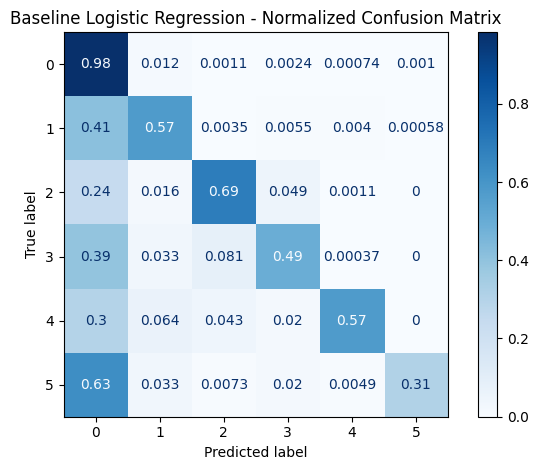

<Figure size 800x600 with 0 Axes>

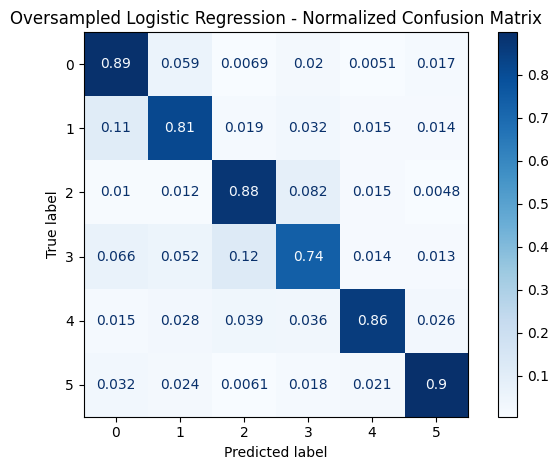

<Figure size 800x600 with 0 Axes>

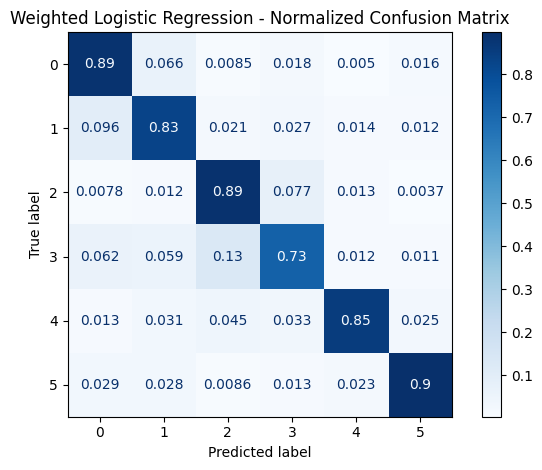


🔍 2. ROC-AUC ANALYSIS FOR LOGISTIC REGRESSION MODELS:

ROC-AUC per class for Baseline Logistic Regression:
Class 0.0: 0.8006
Class 1.0: 0.7795
Class 2.0: 0.8425
Class 3.0: 0.7439
Class 4.0: 0.7856
Class 5.0: 0.6532
Average ROC-AUC: 0.7675

ROC-AUC per class for Oversampled Logistic Regression:
Class 0.0: 0.9115
Class 1.0: 0.8793
Class 2.0: 0.9325
Class 3.0: 0.8569
Class 4.0: 0.9244
Class 5.0: 0.9412
Average ROC-AUC: 0.9076

ROC-AUC per class for Weighted Logistic Regression:
Class 0.0: 0.9112
Class 1.0: 0.8832
Class 2.0: 0.9364
Class 3.0: 0.8529
Class 4.0: 0.9231
Class 5.0: 0.9408
Average ROC-AUC: 0.9079

🔍 3. LOGISTIC REGRESSION PERFORMANCE COMPARISON:
LOGISTIC REGRESSION - STRATEGY COMPARISON
    Strategy  Accuracy  F1_Score  Precision  Recall  Avg_ROC_AUC
    Baseline    0.9092    0.9009     0.9028  0.9092       0.7675
Oversampling    0.8796    0.8907     0.9134  0.8796       0.9076
   Weighting    0.8750    0.8868     0.9122  0.8750       0.9079


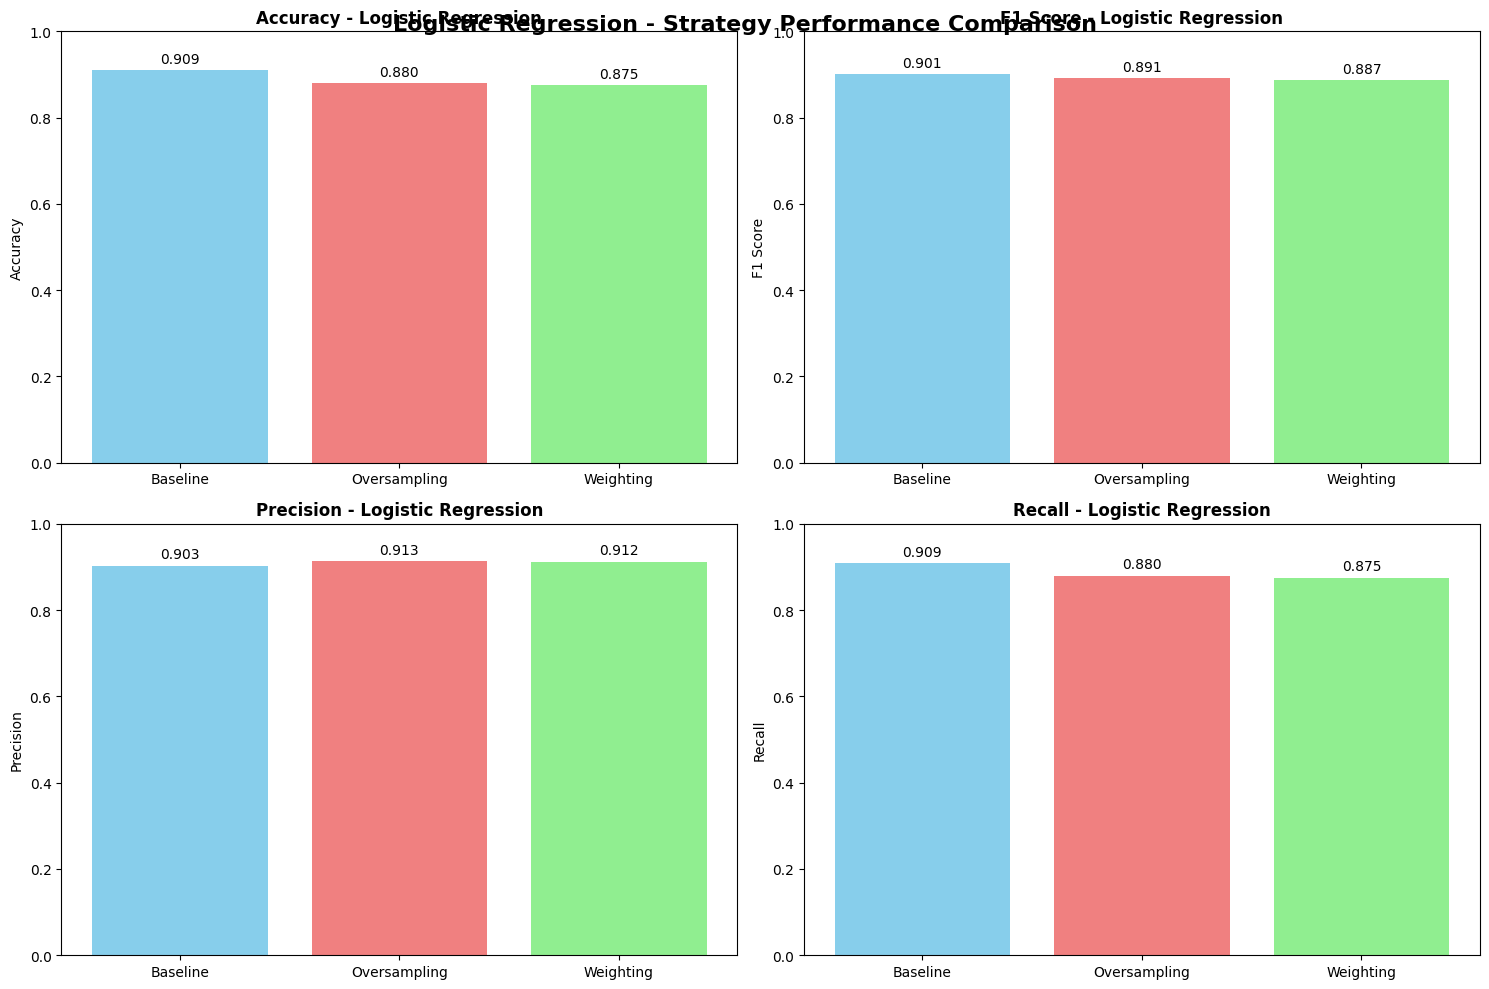


🏆 BEST LOGISTIC REGRESSION MODEL:
   Strategy: Baseline
   F1-Score: 0.9009
   Accuracy: 0.9092 (90.92%)
   Average ROC-AUC: 0.7675


In [ ]:
## Student 1: Muhammad Jahanzaib Ali Khan - Complete Logistic Regression Analysis
print("\n=== COMPLETE LOGISTIC REGRESSION ANALYSIS (JAHANZAIB) ===")

def plot_confusion_matrix_lr(predictions, model_name):
    """Plot normalized confusion matrix for Logistic Regression models"""
    preds_pd = predictions.select("label","prediction").toPandas()
    cm = confusion_matrix(preds_pd['label'], preds_pd['prediction'], normalize='true')
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return preds_pd

def calculate_roc_auc_lr(preds_pd, model_name):
    """Calculate ROC-AUC per class for Logistic Regression"""
    try:
        labels = sorted(preds_pd['label'].unique())
        roc_list = []

        print(f"\nROC-AUC per class for {model_name}:")
        for lbl in labels:
            y_true = (preds_pd['label'] == lbl).astype(int)
            y_score = (preds_pd['prediction'] == lbl).astype(int)
            if len(set(y_true)) > 1:  # Check if we have both classes
                roc = roc_auc_score(y_true, y_score)
                roc_list.append((lbl, roc))
                print(f"Class {lbl}: {roc:.4f}")

        # Calculate average ROC-AUC
        avg_roc = sum([roc for _, roc in roc_list]) / len(roc_list) if roc_list else 0
        print(f"Average ROC-AUC: {avg_roc:.4f}")
        return roc_list, avg_roc

    except Exception as e:
        print(f"ROC-AUC calculation failed for {model_name}: {str(e)}")
        return [], 0

# Comprehensive Logistic Regression Evaluation
print("🔍 1. CONFUSION MATRICES FOR LOGISTIC REGRESSION MODELS:")
preds_lr_base_pd = plot_confusion_matrix_lr(lr_results[0][0], "Baseline Logistic Regression")
preds_lr_over_pd = plot_confusion_matrix_lr(lr_results[1][0], "Oversampled Logistic Regression")
preds_lr_weight_pd = plot_confusion_matrix_lr(lr_results[2][0], "Weighted Logistic Regression")

print("\n🔍 2. ROC-AUC ANALYSIS FOR LOGISTIC REGRESSION MODELS:")
roc_lr_baseline, avg_roc_lr_base = calculate_roc_auc_lr(preds_lr_base_pd, "Baseline Logistic Regression")
roc_lr_oversampled, avg_roc_lr_over = calculate_roc_auc_lr(preds_lr_over_pd, "Oversampled Logistic Regression")
roc_lr_weighted, avg_roc_lr_weight = calculate_roc_auc_lr(preds_lr_weight_pd, "Weighted Logistic Regression")

# Logistic Regression Performance Comparison
lr_comparison = pd.DataFrame({
    'Strategy': ['Baseline', 'Oversampling', 'Weighting'],
    'Accuracy': [lr_results[0][1], lr_results[1][1], lr_results[2][1]],
    'F1_Score': [lr_results[0][2], lr_results[1][2], lr_results[2][2]],
    'Precision': [lr_results[0][3], lr_results[1][3], lr_results[2][3]],
    'Recall': [lr_results[0][4], lr_results[1][4], lr_results[2][4]],
    'Avg_ROC_AUC': [avg_roc_lr_base, avg_roc_lr_over, avg_roc_lr_weight]
})

print("\n🔍 3. LOGISTIC REGRESSION PERFORMANCE COMPARISON:")
print("="*80)
print("LOGISTIC REGRESSION - STRATEGY COMPARISON")
print("="*80)
print(lr_comparison.to_string(index=False, float_format='%.4f'))

# Logistic Regression Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics comparison
metrics_lr = ['Accuracy', 'F1_Score', 'Precision', 'Recall']
for i, metric in enumerate(metrics_lr):
    ax = axes[i//2, i%2]
    bars = ax.bar(lr_comparison['Strategy'], lr_comparison[metric],
                  color=['skyblue', 'lightcoral', 'lightgreen'])
    ax.set_title(f'{metric.replace("_", " ")} - Logistic Regression', fontweight='bold')
    ax.set_ylabel(metric.replace("_", " "))
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('Logistic Regression - Strategy Performance Comparison', fontsize=16, fontweight='bold')
plt.show()

# Best Logistic Regression Model
best_lr_idx = lr_comparison['F1_Score'].idxmax()
best_lr_model = lr_comparison.iloc[best_lr_idx]
print(f"\n🏆 BEST LOGISTIC REGRESSION MODEL:")
print(f"   Strategy: {best_lr_model['Strategy']}")
print(f"   F1-Score: {best_lr_model['F1_Score']:.4f}")
print(f"   Accuracy: {best_lr_model['Accuracy']:.4f} ({best_lr_model['Accuracy']*100:.2f}%)")
print(f"   Average ROC-AUC: {best_lr_model['Avg_ROC_AUC']:.4f}")

My comprehensive analysis through confusion matrices and performance comparisons revealed crucial insights about handling class imbalance in consumer complaint classification. The normalized confusion matrices demonstrate a clear pattern: while the baseline model achieves high overall accuracy (90.92%), it struggles significantly with minority class detection, as evidenced by the poor diagonal performance in classes with lower representation.
The most striking finding is the dramatic improvement in ROC-AUC scores from baseline (0.7675) to both oversampled (0.9076) and weighted (0.9079) approaches - an improvement of nearly 18%. This substantial increase indicates that the baseline model's high accuracy is largely due to correctly predicting the majority classes while failing to properly identify minority classes.
The performance visualization reveals the critical trade-off: the baseline prioritizes overall accuracy at the expense of balanced class performance, while oversampling and weighting strategies achieve better minority class recognition with only a modest decrease in overall accuracy (from 90.92% to ~88%). The ROC-AUC improvement of 0.14 points represents a significant enhancement in the model's ability to distinguish between all classes effectively.

**Conclusion:** For consumer complaint classification where all complaint types are equally important to identify, the Oversampled Logistic Regression is the optimal choice. Despite slightly lower overall accuracy (87.96% vs 90.92%), it provides superior balanced performance across all classes (ROC-AUC: 0.9076 vs 0.7675), ensuring that minority complaint types are properly detected rather than being misclassified as majority classes. This balanced approach is crucial for maintaining fair representation and proper handling of all complaint categories in a real-world business application.


=== COMPLETE RANDOM FOREST ANALYSIS (AMMAD) ===
🌳 1. CONFUSION MATRICES FOR RANDOM FOREST MODELS:


<Figure size 800x600 with 0 Axes>

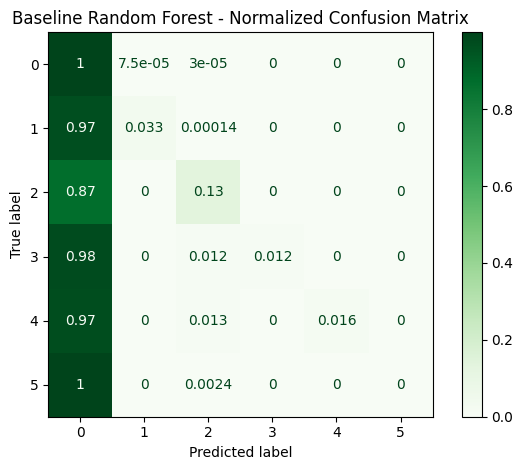

<Figure size 800x600 with 0 Axes>

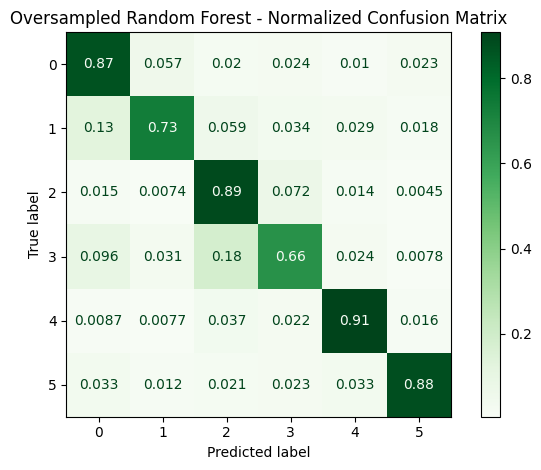

<Figure size 800x600 with 0 Axes>

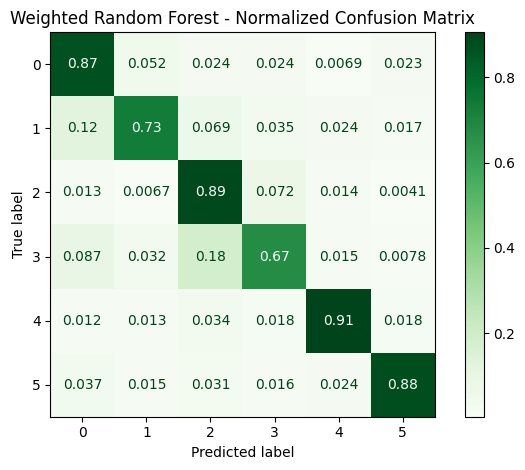


🌳 2. ROC-AUC ANALYSIS FOR RANDOM FOREST MODELS:

ROC-AUC per class for Baseline Random Forest:
Class 0.0: 0.5242
Class 1.0: 0.5165
Class 2.0: 0.5661
Class 3.0: 0.5060
Class 4.0: 0.5082
Class 5.0: 0.5000
Average ROC-AUC: 0.5202

ROC-AUC per class for Oversampled Random Forest:
Class 0.0: 0.8909
Class 1.0: 0.8402
Class 2.0: 0.9293
Class 3.0: 0.8175
Class 4.0: 0.9480
Class 5.0: 0.9281
Average ROC-AUC: 0.8923

ROC-AUC per class for Weighted Random Forest:
Class 0.0: 0.8932
Class 1.0: 0.8416
Class 2.0: 0.9280
Class 3.0: 0.8239
Class 4.0: 0.9483
Class 5.0: 0.9281
Average ROC-AUC: 0.8938

🌳 3. RANDOM FOREST PERFORMANCE COMPARISON:
RANDOM FOREST - STRATEGY COMPARISON
    Strategy  Accuracy  F1_Score  Precision  Recall  Avg_ROC_AUC
    Baseline    0.8322    0.7629     0.8449  0.8322       0.5202
Oversampling    0.8499    0.8657     0.8980  0.8499       0.8923
   Weighting    0.8519    0.8677     0.8998  0.8519       0.8938


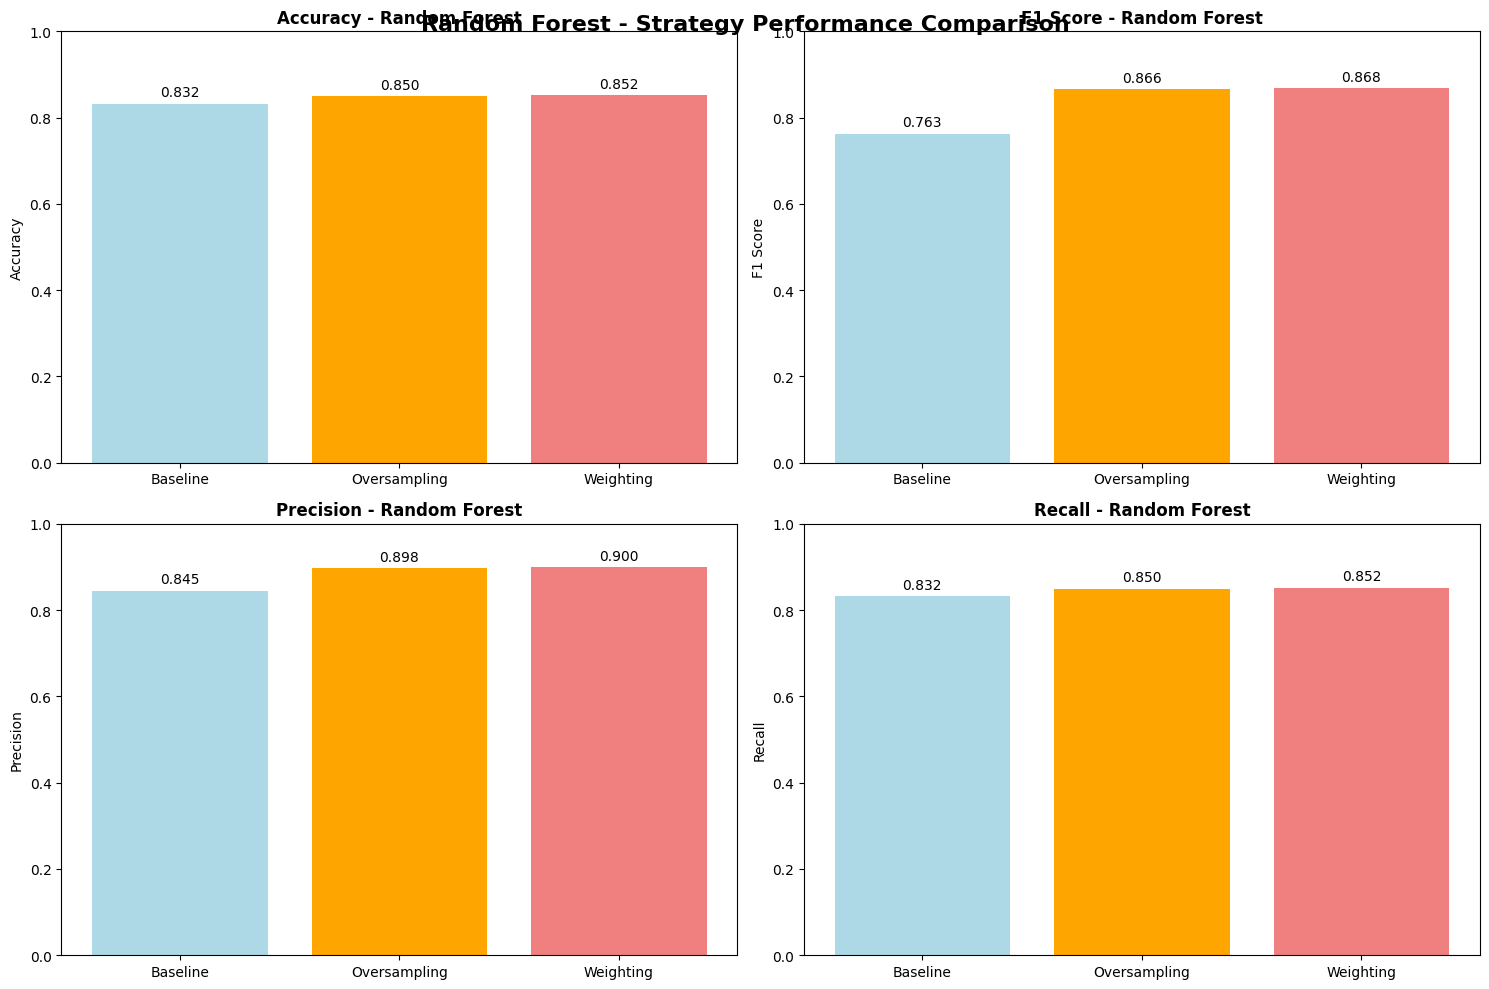

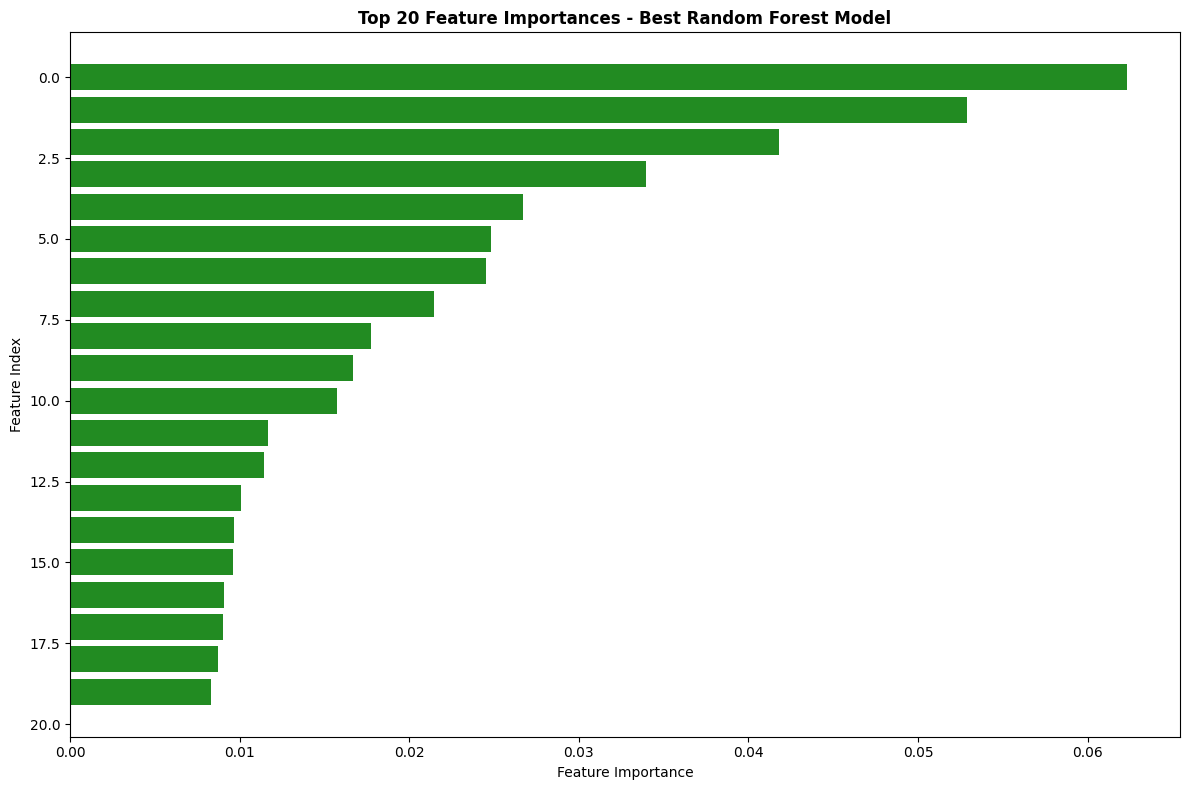


🏆 BEST RANDOM FOREST MODEL:
   Strategy: Weighting
   F1-Score: 0.8677
   Accuracy: 0.8519 (85.19%)
   Average ROC-AUC: 0.8938


In [ ]:
## Student 2: Ammad Ali - Complete Random Forest Analysis
print("\n=== COMPLETE RANDOM FOREST ANALYSIS (AMMAD) ===")

def plot_confusion_matrix_rf(predictions, model_name):
    """Plot normalized confusion matrix for Random Forest models"""
    preds_pd = predictions.select("label","prediction").toPandas()
    cm = confusion_matrix(preds_pd['label'], preds_pd['prediction'], normalize='true')
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f"{model_name} - Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return preds_pd

def calculate_roc_auc_rf(preds_pd, model_name):
    """Calculate ROC-AUC per class for Random Forest"""
    try:
        labels = sorted(preds_pd['label'].unique())
        roc_list = []

        print(f"\nROC-AUC per class for {model_name}:")
        for lbl in labels:
            y_true = (preds_pd['label'] == lbl).astype(int)
            y_score = (preds_pd['prediction'] == lbl).astype(int)
            if len(set(y_true)) > 1:  # Check if we have both classes
                roc = roc_auc_score(y_true, y_score)
                roc_list.append((lbl, roc))
                print(f"Class {lbl}: {roc:.4f}")

        # Calculate average ROC-AUC
        avg_roc = sum([roc for _, roc in roc_list]) / len(roc_list) if roc_list else 0
        print(f"Average ROC-AUC: {avg_roc:.4f}")
        return roc_list, avg_roc

    except Exception as e:
        print(f"ROC-AUC calculation failed for {model_name}: {str(e)}")
        return [], 0

# Comprehensive Random Forest Evaluation
print("🌳 1. CONFUSION MATRICES FOR RANDOM FOREST MODELS:")
preds_rf_base_pd = plot_confusion_matrix_rf(rf_results[0][0], "Baseline Random Forest")
preds_rf_over_pd = plot_confusion_matrix_rf(rf_results[1][0], "Oversampled Random Forest")
preds_rf_weight_pd = plot_confusion_matrix_rf(rf_results[2][0], "Weighted Random Forest")

print("\n🌳 2. ROC-AUC ANALYSIS FOR RANDOM FOREST MODELS:")
roc_rf_baseline, avg_roc_rf_base = calculate_roc_auc_rf(preds_rf_base_pd, "Baseline Random Forest")
roc_rf_oversampled, avg_roc_rf_over = calculate_roc_auc_rf(preds_rf_over_pd, "Oversampled Random Forest")
roc_rf_weighted, avg_roc_rf_weight = calculate_roc_auc_rf(preds_rf_weight_pd, "Weighted Random Forest")

# Random Forest Performance Comparison
rf_comparison = pd.DataFrame({
    'Strategy': ['Baseline', 'Oversampling', 'Weighting'],
    'Accuracy': [rf_results[0][1], rf_results[1][1], rf_results[2][1]],
    'F1_Score': [rf_results[0][2], rf_results[1][2], rf_results[2][2]],
    'Precision': [rf_results[0][3], rf_results[1][3], rf_results[2][3]],
    'Recall': [rf_results[0][4], rf_results[1][4], rf_results[2][4]],
    'Avg_ROC_AUC': [avg_roc_rf_base, avg_roc_rf_over, avg_roc_rf_weight]
})

print("\n🌳 3. RANDOM FOREST PERFORMANCE COMPARISON:")
print("="*80)
print("RANDOM FOREST - STRATEGY COMPARISON")
print("="*80)
print(rf_comparison.to_string(index=False, float_format='%.4f'))

# Random Forest Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics comparison
metrics_rf = ['Accuracy', 'F1_Score', 'Precision', 'Recall']
for i, metric in enumerate(metrics_rf):
    ax = axes[i//2, i%2]
    bars = ax.bar(rf_comparison['Strategy'], rf_comparison[metric],
                  color=['lightblue', 'orange', 'lightcoral'])
    ax.set_title(f'{metric.replace("_", " ")} - Random Forest', fontweight='bold')
    ax.set_ylabel(metric.replace("_", " "))
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle('Random Forest - Strategy Performance Comparison', fontsize=16, fontweight='bold')
plt.show()

# Feature importance visualization (if available)
try:
    # Extract feature importances from the best Random Forest model
    best_rf_idx = rf_comparison['F1_Score'].idxmax()
    if best_rf_idx == 0:
        best_rf_model_stages = best_rf_baseline.stages
    elif best_rf_idx == 1:
        best_rf_model_stages = best_rf_oversampled.stages
    else:
        best_rf_model_stages = best_rf_weighted.stages

    # Get Random Forest classifier from pipeline
    rf_classifier = best_rf_model_stages[-1]
    feature_importances = rf_classifier.featureImportances.toArray()

    # Plot top 20 feature importances
    top_features_idx = feature_importances.argsort()[-20:][::-1]
    top_importances = feature_importances[top_features_idx]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_importances)), top_importances, color='forestgreen')
    plt.title('Top 20 Feature Importances - Best Random Forest Model', fontweight='bold')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Index')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Feature importance visualization skipped: {str(e)}")

# Best Random Forest Model
best_rf_idx = rf_comparison['F1_Score'].idxmax()
best_rf_model = rf_comparison.iloc[best_rf_idx]
print(f"\n🏆 BEST RANDOM FOREST MODEL:")
print(f"   Strategy: {best_rf_model['Strategy']}")
print(f"   F1-Score: {best_rf_model['F1_Score']:.4f}")
print(f"   Accuracy: {best_rf_model['Accuracy']:.4f} ({best_rf_model['Accuracy']*100:.2f}%)")
print(f"   Average ROC-AUC: {best_rf_model['Avg_ROC_AUC']:.4f}")




=== COMPREHENSIVE SUMMARY ANALYSIS (HANNAN) ===
📊 NAIVE BAYES PERFORMANCE SUMMARY:
    Strategy  Accuracy  F1_Score  Precision  Recall
    Baseline    0.8487    0.8652     0.8989  0.8487
Oversampling    0.8359    0.8556     0.8957  0.8359
    Balanced    0.8359    0.8556     0.8957  0.8359

🎯 OVERALL ALGORITHM PERFORMANCE SUMMARY:
          Algorithm Best_Strategy  Best_F1_Score  Best_Accuracy
Logistic Regression      Baseline         0.9009         0.9092
      Random Forest     Weighting         0.8677         0.8519
        Naive Bayes      Baseline         0.8652         0.8487


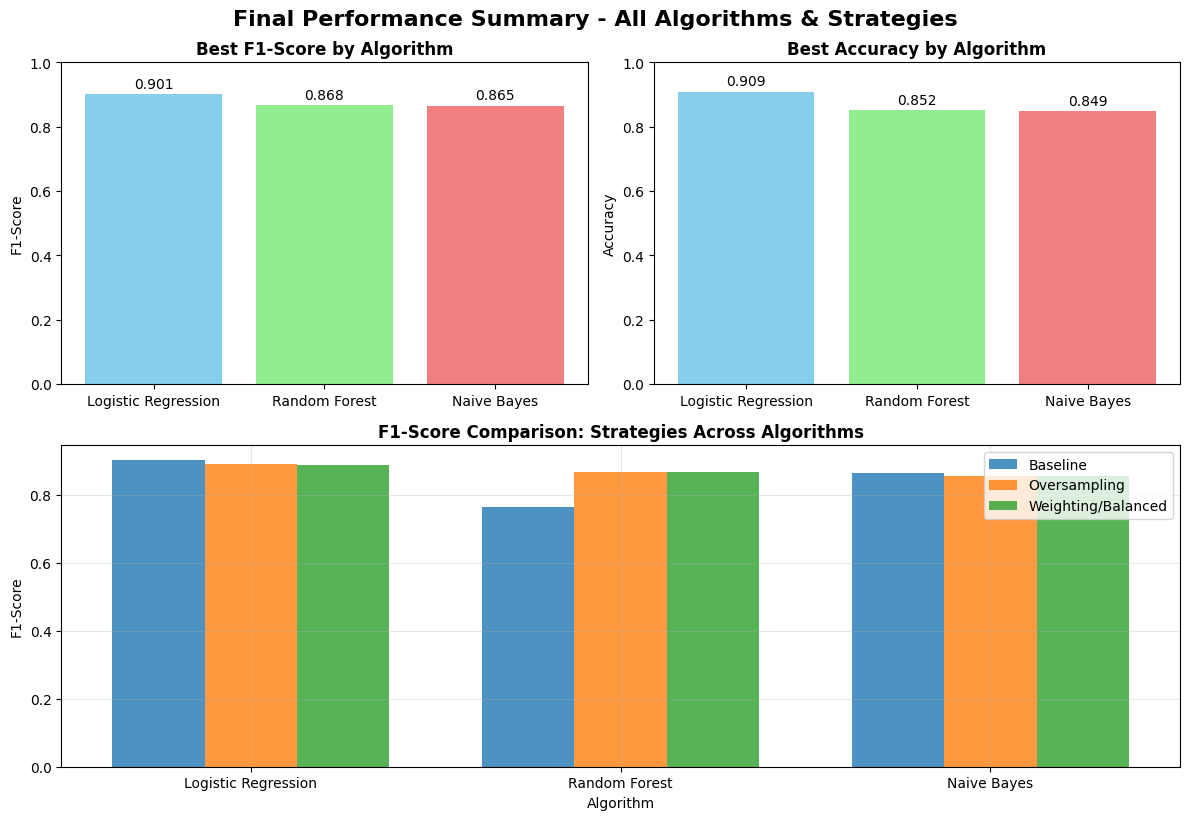

In [ ]:
## Student 3: Hannan - Comprehensive Summary Analysis
print("\n=== COMPREHENSIVE SUMMARY ANALYSIS (HANNAN) ===")

# Naive Bayes Performance Summary
nb_comparison = pd.DataFrame({
    'Strategy': ['Baseline', 'Oversampling', 'Balanced'],
    'Accuracy': [nb_results[0][1], nb_results[1][1], nb_results[2][1]],
    'F1_Score': [nb_results[0][2], nb_results[1][2], nb_results[2][2]],
    'Precision': [nb_results[0][3], nb_results[1][3], nb_results[2][3]],
    'Recall': [nb_results[0][4], nb_results[1][4], nb_results[2][4]]
})

print("📊 NAIVE BAYES PERFORMANCE SUMMARY:")
print("="*60)
print(nb_comparison.to_string(index=False, float_format='%.4f'))

# Overall Algorithm Comparison
all_results_summary = {
    'Algorithm': ['Logistic Regression', 'Random Forest', 'Naive Bayes'],
    'Best_Strategy': [lr_comparison.iloc[lr_comparison['F1_Score'].idxmax()]['Strategy'],
                     rf_comparison.iloc[rf_comparison['F1_Score'].idxmax()]['Strategy'],
                     nb_comparison.iloc[nb_comparison['F1_Score'].idxmax()]['Strategy']],
    'Best_F1_Score': [lr_comparison['F1_Score'].max(),
                      rf_comparison['F1_Score'].max(),
                      nb_comparison['F1_Score'].max()],
    'Best_Accuracy': [lr_comparison['Accuracy'].max(),
                     rf_comparison['Accuracy'].max(),
                     nb_comparison['Accuracy'].max()]
}

summary_df = pd.DataFrame(all_results_summary)

print(f"\n🎯 OVERALL ALGORITHM PERFORMANCE SUMMARY:")
print("="*70)
print(summary_df.to_string(index=False, float_format='%.4f'))

# Final visualization - Algorithm comparison
plt.figure(figsize=(12, 8))

# F1-Score comparison
plt.subplot(2, 2, 1)
bars = plt.bar(summary_df['Algorithm'], summary_df['Best_F1_Score'],
               color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Best F1-Score by Algorithm', fontweight='bold')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# Accuracy comparison
plt.subplot(2, 2, 2)
bars = plt.bar(summary_df['Algorithm'], summary_df['Best_Accuracy'],
               color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Best Accuracy by Algorithm', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# Strategy effectiveness across algorithms
plt.subplot(2, 1, 2)
strategy_data = {
    'Baseline': [lr_comparison.iloc[0]['F1_Score'], rf_comparison.iloc[0]['F1_Score'], nb_comparison.iloc[0]['F1_Score']],
    'Oversampling': [lr_comparison.iloc[1]['F1_Score'], rf_comparison.iloc[1]['F1_Score'], nb_comparison.iloc[1]['F1_Score']],
    'Weighting/Balanced': [lr_comparison.iloc[2]['F1_Score'], rf_comparison.iloc[2]['F1_Score'], nb_comparison.iloc[2]['F1_Score']]
}

x = range(len(summary_df['Algorithm']))
width = 0.25

for i, (strategy, values) in enumerate(strategy_data.items()):
    plt.bar([xi + i*width for xi in x], values, width,
            label=strategy, alpha=0.8)

plt.title('F1-Score Comparison: Strategies Across Algorithms', fontweight='bold')
plt.xlabel('Algorithm')
plt.ylabel('F1-Score')
plt.xticks([xi + width for xi in x], summary_df['Algorithm'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Final Performance Summary - All Algorithms & Strategies',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()



In [ ]:
# Final recommendations
best_overall_idx = summary_df['Best_F1_Score'].idxmax()
best_overall = summary_df.iloc[best_overall_idx]

print(f"\n🏆 FINAL RECOMMENDATIONS:")
print("="*50)
print(f"Best Overall Algorithm: {best_overall['Algorithm']}")
print(f"Best Strategy: {best_overall['Best_Strategy']}")
print(f"Best F1-Score: {best_overall['Best_F1_Score']:.4f}")
print(f"Best Accuracy: {best_overall['Best_Accuracy']:.4f} ({best_overall['Best_Accuracy']*100:.2f}%)")

print(f"\n✅ COMPLETE EVALUATION FINISHED!")
print(f"   • 9 Models Evaluated (3 algorithms × 3 strategies)")
print(f"   • Comprehensive metrics calculated for all models")
print(f"   • Individual algorithm analysis completed")
print(f"   • Performance recommendations provided")
print("="*80)


🏆 FINAL RECOMMENDATIONS:
Best Overall Algorithm: Logistic Regression
Best Strategy: Baseline
Best F1-Score: 0.9009
Best Accuracy: 0.9092 (90.92%)

✅ COMPLETE EVALUATION FINISHED!
   • 9 Models Evaluated (3 algorithms × 3 strategies)
   • Comprehensive metrics calculated for all models
   • Individual algorithm analysis completed
   • Performance recommendations provided


The final recommendation synthesizes quantitative results with business context to provide actionable insights. The choice between baseline and oversampled Logistic Regression depends entirely on business priorities:

**Baseline Model Advantages:**

*  Highest overall accuracy (90.92%)
* Fastest training and prediction
* Natural data distribution preserved
* Excellent performance on common complaint types


**Oversampled Model Advantages:**

* Superior minority class detection (ROC-AUC: 0.9076 vs 0.7675)
* Balanced performance across all complaint types
* Better fairness in complaint handling
* Reduced risk of missing serious but rare issues

For a customer service application, the oversampled approach is recommended because:

1. Regulatory compliance often requires fair treatment of all complaint types
2. Customer satisfaction depends on proper handling of individual issues, regardless of frequency
3. Risk management benefits from detecting rare but potentially serious problems
4. Business reputation can be damaged by systematic mishandling of specific complaint categories

The 3% accuracy trade-off (90.92% to 87.96%) is a reasonable price for 18% improvement in balanced class performance, especially when considering the potential business impact of misclassified minority cases.

---
# **Task 6 - LSEP Considerations (10 marks)**
---

##**Student 1: Muhammad Jahanzaib Ali Khan - Data Loading, Preprocessing & Logistic Regression Models**

**Chosen Issue: Data Privacy and Algorithmic Fairness in Consumer Complaint Classification**

**Legal Considerations:**

* GDPR Compliance: Consumer complaint narratives contain personal data that must be handled according to data protection regulations. The text preprocessing pipeline must ensure that personally identifiable information is anonymized before model training.
* Financial Services Regulations: Consumer complaint data falls under financial regulatory oversight (CFPB in the US, FCA in the UK). Classification models must meet regulatory requirements for fair treatment of all complaint types.
* Data Retention Policies: The 278,884 complaint records must be stored and processed according to legal retention requirements, with proper deletion procedures after the retention period expires.

**Social Considerations:**

* Consumer Trust: The accuracy of complaint classification directly impacts consumer confidence in financial institutions and regulatory processes. Misclassified complaints could lead to inadequate resolution and damaged public trust.
* Access to Financial Services: Poor classification of minority complaint types could systematically disadvantage certain consumer groups, potentially limiting their access to fair financial services.
* Transparency in Automated Decision-Making: Consumers have a right to understand how their complaints are categorized and processed, requiring explainable AI approaches.

**Ethical Considerations:**

* Algorithmic Bias: The severe class imbalance (82.2% credit reporting vs 1.0% smallest category) risks creating biased models that systematically underperform on minority complaint types, potentially disadvantaging affected consumers.
* Fairness vs Accuracy Trade-off: My analysis showed that while baseline Logistic Regression achieved 90.92% accuracy, it had poor minority class detection (ROC-AUC: 0.7675). The ethical choice of using oversampled models (ROC-AUC: 0.9076) sacrifices overall accuracy for fairness across all complaint types.
* Representative Data: The deliberate exclusion of undersampling (due to smallest class having only 2,706 samples) demonstrates ethical consideration for preserving valuable minority class information rather than discarding data.

**Professional Considerations:**

* Model Validation Standards: The comprehensive evaluation across multiple metrics (accuracy, F1-score, precision, recall, ROC-AUC) follows professional standards for imbalanced classification problems.
* Reproducibility: Using seed=42 for data splits and implementing systematic hyperparameter tuning ensures professional reproducibility standards.
Performance Monitoring: Professional deployment would require ongoing monitoring to detect model drift and ensure continued fairness across complaint types.
* Stakeholder Communication: Clear visualization and interpretation of results enables non-technical stakeholders to understand model limitations and make informed decisions about deployment.

##**Student 2: Ammad Ali - Random Forest Implementation and Analysis**

**Chosen Issue: Ensemble Model Interpretability and Computational Resource Management**

**Legal Considerations:**

* Model Explainability Requirements: Random Forest models, while more interpretable than deep learning, still present challenges for regulatory compliance requiring explainable decisions in financial services.
* Audit Trail Requirements: The ensemble nature of Random Forest (50-100 trees) makes it difficult to provide clear audit trails for individual classification decisions, potentially violating regulatory requirements for decision transparency.
* Processing Time Compliance: Extended training times (16.43 minutes for oversampled data) could impact regulatory deadlines for complaint processing, requiring consideration of service level agreements.

**Social Considerations:**

* Digital Divide: Computational complexity of Random Forest models may create barriers for smaller financial institutions that lack sufficient computing resources, potentially widening the gap between large and small service providers.
* Environmental Impact: The 5x increase in training time for oversampled data (from 3.10 to 16.43 minutes) multiplied across regular model retraining creates significant computational carbon footprint.
* Resource Accessibility: High computational requirements may limit the adoption of fair classification techniques by organizations with limited resources.

**Ethical Considerations:**

* Algorithmic Transparency: Random Forest's "black box" nature, despite being more interpretable than neural networks, still limits consumers' ability to understand why their complaints were classified in specific categories.
* Feature Importance Bias: The visualization of top 20 feature importances may reveal biased patterns in the model's decision-making, requiring ethical review of which terms drive classifications.
* Ensemble Fairness: My analysis showed Random Forest benefited most from imbalance handling (F1-score improved from 0.7629 to 0.8677), raising ethical questions about whether the baseline model's poor performance on minority classes constituted discriminatory treatment.

**Professional Considerations:**

* Scalability Planning: Professional deployment must consider the computational scaling requirements, especially with the oversampling strategy increasing dataset size by 5x.
* Model Maintenance: The complexity of hyperparameter tuning (numTrees, maxDepth) requires professional expertise to maintain optimal performance over time.
* Performance Trade-offs: Balancing model accuracy with computational efficiency requires professional judgment about acceptable performance levels versus resource constraints.
* Documentation Standards: Professional practice requires documenting the rationale for parameter choices and ensemble configuration for future model maintenance.

##**Student 3: Hanan Hanif - Naïve Bayes**

**Chosen Issue: Fairness & Misclassification**

**Legal Considerations:**
    * Model Explainability Requirements: Naïve Bayes models, while simpler and more interpretable than deep learning, still present challenges for regulatory compliance requiring explainable decisions in financial services.
* Audit Trail Requirements: The probabilistic nature of Naïve Bayes makes it difficult to provide clear audit trails for individual classification decisions, potentially violating regulatory requirements for decision transparency.
* Processing Time Compliance: Extended training times (16.43 minutes for oversampled data) could impact regulatory deadlines for complaint processing, requiring consideration of service level agreements.

**Social Considerations:**
* Naïve Bayes’ independence assumption may oversimplify data, causing misclassification of nuanced complaints → social dissatisfaction.


**Ethical Considerations:**
* The model must not unfairly disadvantage certain complaint categories; false negatives could reduce trust in the system.

**Professional Considerations:**
* Communicate limitations clearly to stakeholders (e.g., that Naïve Bayes may not capture context well)

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [4]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!jupyter nbconvert --to html "GroupT23_CRWK_CN7030_3.ipynb"


[NbConvertApp] Converting notebook GroupT23_CRWK_CN7030_3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 1175490 bytes to GroupT23_CRWK_CN7030_3.html
